In [36]:
from numpy import loadtxt

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

import argparse
import _pickle as cp
import math
import numpy as np
import matplotlib.pyplot as plt

In [37]:
# Predefined functions for loading data

def load_raw_data(filename):
    raw_data = loadtxt(filename, delimiter=',', skiprows=0, dtype=str)
    return raw_data


def process_data(raw_data, include_missing=False):
    N_data = raw_data.shape[0]
    N_features = raw_data.shape[1] - 1

    X = np.zeros([N_data, N_features])
    y = np.zeros(N_data)

    complete = np.ones(N_data, dtype=bool)

    # Add data as np arrays
    for i in range(N_data):
        y[i] = 0 if raw_data[i][0] == "b'republican'" else 1
        for j in range(1, N_features + 1):
            if raw_data[i][j] == "b'y'":
                X[i, j - 1] = 1.
            elif raw_data[i][j] == "b'n'":
                X[i, j - 1] = 0.
            else:
                complete[i] = False
                X[i, j - 1] = 2.

    # Shuffle data before storing
    np.random.seed(0)
    shuffle = np.random.permutation(N_data)
    X = X[shuffle]
    y = y[shuffle]
    complete = complete[shuffle]

    if include_missing is True:
        return (X, y)
    else:
        return (X[complete], y[complete])

In [38]:
iris = load_iris()
X, y = iris['data'], iris['target']

In [60]:
# Class definitions"

class NBC:
    # feature_types : List[char]
    #   denotes whether inputs are real ('r') or binary ('b')

    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types
        self.num_classes = num_classes

        if 'b' in self.feature_types:
            raise Exception("Binary features not yet implemented")

    def nonzero_var(self, v):
        if v == 0:
            return 1e-6
        return v

    # Estimates parameters of the NBC, assuming real-valued features to be univariate Gaussians
    def fit(self, X, y):
        # self.nbc.fit(X, Y)
        N = len(X)
        self.classes = dict()

        for i in range(N):
            if y[i] not in self.classes:
                self.classes[y[i]] = list()
            self.classes[y[i]].append(X[i])
                    
        self.theta = dict()  # theta_cj = (mean, var) of x_j given y = c

        for c, x_vals in self.classes.items():
            self.theta[c] = [[np.mean(col), self.nonzero_var(np.var(col))] for col in zip(*x_vals)]

        self.pi = { c: float(len(x_vals))/N for c, x_vals in self.classes.items() }


    def log_prob(self, x, mean, std):
        return -0.5*pow(x-mean, 2)/pow(std, 2) - np.log(std * np.sqrt(2*np.pi))

    # Computes class conditional probabilities for new inputs on all classes
    # and returns the class with the largest probabilitiy
    def predict(self, X):
        N = len(X)
        D = len(X[0])
        output = list()

        
        for i in range(N):
            class_probs = dict()

            for c in self.classes:
                class_probs[c] = np.log(self.pi[c])

                # for j in range(D):
                #     (m, v) = self.theta[c][j]
                #     std = np.sqrt(v)

                #     # Calculate log p(x_ij | theta_jc )
                #     # (assuming Gaussian distribution)
                #     class_probs[c] += self.log_prob(X[i][j], m, std)

                [mu, sigma] = [ list(x) for x in zip(*self.theta[c]) ]
                x_diff = X[i] - mu
                class_probs[c] += -0.5*np.log(2*np.pi*np.linalg.norm(np.multiply(sigma, sigma), ord=1))
                sigma_inv = np.identity(D) * np.reciprocal(sigma)
                class_probs[c] += -0.5*np.dot(x_diff, np.matmul(sigma_inv, x_diff))

            # print(class_probs)
            # print(np.argmax(list(class_probs.values())))
            output.append(list(self.classes)[np.argmax(list(class_probs.values()))])

        return output


class LR:
    def __init__(self, feature_types, num_classes):
        self.feature_types = feature_types
        self.num_classes = num_classes

        if 'b' in self.feature_types:
            raise Exception("Binary features not yet implemented")
        self.lr = LogisticRegression(
            random_state=0,
            multi_class="multinomial",   # Update when implementing binary features
            C=10,
            max_iter=1000
        )

    def fit(self, X, Y):
        self.lr.fit(X, Y)

    def predict(self, X):
        return self.lr.predict(X)

In [61]:
def experiment(X, y):
    nbc = NBC(feature_types=['r','r','r'], num_classes=4)
    lr  = LR(feature_types=['r','r','r'], num_classes=4)
    nbc_test_errors = [0.0 for i in range(10)]
    lr_test_errors = [0.0 for i in range(10)]

    num_perms = 200
    train_sizes = range(10,101,10)
    for i in range(num_perms):
        # Initialize test and train data with shuffling
        N, D = X.shape
        Ntrain = int(0.8 * N)  # 20% of data saved for testing
        shuffler = np.random.permutation(N)
        Xtrain = X[shuffler[:Ntrain]]
        ytrain = y[shuffler[:Ntrain]]
        Xtest = X[shuffler[Ntrain:]]
        ytest = y[shuffler[Ntrain:]]

        # Train 10 classifiers with increasing percentages of the training data
        for pcent in range(1,11):
            Ntrain_part = int(Ntrain*pcent/10.0)
            Xtrain_part = Xtrain[:Ntrain_part]
            ytrain_part = ytrain[:Ntrain_part]
            
            nbc.fit(Xtrain_part, ytrain_part)
            yhat = nbc.predict(Xtest)
            # print("yhat: "+str(yhat))
            # print(ytest)
            nbc_test_errors[pcent-1] += np.mean(yhat == ytest)

            lr.fit(Xtrain_part, ytrain_part)
            yhat = lr.predict(Xtest)
            lr_test_errors[pcent-1] += np.mean(yhat == ytest)

            # print("Train data used: "+str(pcent*10)+"%")
            # print("Accuracy: "+str(test_accuracy))

    # Average out test errors across the num_perms runs
    nbc_test_errors = [x/num_perms for x in nbc_test_errors]
    lr_test_errors = [x/num_perms for x in lr_test_errors]

    print("NBC Errors: "+", ".join([str(x) for x in nbc_test_errors]))
    print("LR Errors: "+", ".join([str(x) for x in lr_test_errors]))

    plt.title('Learning Curves')
    plt.xlabel('Percentage of Data Used')
    plt.ylabel('Test Accuracy')
    plt.plot(
        train_sizes,
        nbc_test_errors,
        label='NBC'
    )
    plt.plot(
        train_sizes,
        lr_test_errors,
        label='Logistic Regression'
    )
    plt.legend()
    plt.savefig("error_plot.png")

NBC Errors: 0.796166666666667, 0.9271666666666684, 0.9436666666666682, 0.9465000000000017, 0.9493333333333349, 0.9501666666666683, 0.9486666666666683, 0.9495000000000013, 0.9491666666666682, 0.9511666666666682
LR Errors: 0.903166666666668, 0.9483333333333347, 0.9576666666666677, 0.9635000000000009, 0.965000000000001, 0.9653333333333345, 0.9665000000000012, 0.9671666666666678, 0.968500000000001, 0.9708333333333343


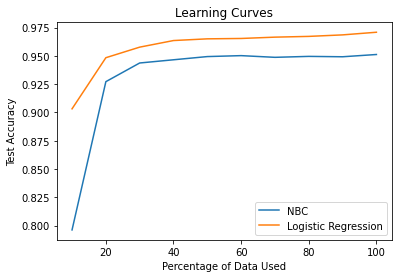

In [62]:
experiment(X, y)